In [1]:
import pandas as pd
import scipy.stats as stats
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Preparation of the data

First, we need to prepare the data. The very first step is to concatenate the information in all the files we scraped from IsAcademia. (Reminder: We have one file per year.) The function `concatFiles` opens all the files and then return a DataFrame.

In [2]:
# requires os
def concatFiles(direc, fileType):
    files = os.listdir(direc)
    if '.DS_Store' in files:
        files.remove('.DS_Store')
    if fileType == 'csv':
        r = pd.read_csv
    for idx, file in enumerate(files):
        file = direc+file
        if idx == 0:
            df = r(file, header=0)
        else:
            new = r(file, header=0)
            df = pd.concat([df, new], axis=0)
    return df

In [3]:
info = concatFiles('data/', 'csv')
# Print the head of the big DataFrame
info.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Subject,Period,Semester
0,Monsieur,Bouaziz Sofien,NaN,NaN,NaN,NaN,NaN,Présent,Erasmus,Ecole Supérieure d'Ingénieurs en Electronique ...,179749,Informatique,2007-2008,Semestre automne
1,Monsieur,Charles Christian,NaN,NaN,NaN,NaN,NaN,Présent,Erasmus,Ecole Supérieure de Chimie Physique Electroniq...,180104,Informatique,2007-2008,Semestre automne
2,Monsieur,Dagand Pierre-Evariste,NaN,NaN,NaN,NaN,NaN,Présent,Erasmus,Ecole Normale Supérieure de Cachan,181031,Informatique,2007-2008,Semestre automne
3,Monsieur,Grataloup Olivier,NaN,NaN,NaN,NaN,NaN,Présent,Erasmus,Ecole Supérieure de Chimie Physique Electroniq...,179911,Informatique,2007-2008,Semestre automne
4,Monsieur,Grignard Arnaud,NaN,NaN,NaN,NaN,NaN,Présent,Erasmus,Ecole Supérieure de Chimie Physique Electroniq...,179934,Informatique,2007-2008,Semestre automne


In this exercise, we are looking for Master students. Therefore, we can create a function that will locate if the *Semester* field contains the word *Master*.

In [4]:
def locator_ma(s):
    return s.find('Master') != -1

In [5]:
ma = info.loc[info['Semester'].apply(locator_ma)]
ma.head()


,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Subject,Period,Semester
369,Monsieur,Aeberhard François-Xavier,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,153066,Informatique,2007-2008,Master semestre 1
370,Madame,Agarwal Megha,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,180027,Informatique,2007-2008,Master semestre 1
371,Monsieur,Anagnostaras David,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,152232,Informatique,2007-2008,Master semestre 1
372,Monsieur,Auroux Damien,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,177395,Informatique,2007-2008,Master semestre 1
373,Monsieur,Awalebo Joseph,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,161970,Informatique,2007-2008,Master semestre 1


Next step is to locate the *sciper* number. Indeed, it's easier to deal with a number than with a complicated name.

In [6]:
def locSciper(df, sciper):
    return df.loc[df['No Sciper'] == sciper]

We collect the *Gender*.

In [7]:
def getGender(df):
    """ Take a DataFrame and checks the gender
    
    Args:
        df (DataFrame): a DataFrame, typically a .loc on a specific student
        
    Returns:
        bool: True if student is a woman, False otherwise
    """
    try:
        if df.isin(['Madame'])['Civilité'].value_counts()[True] > 0:
            return 1
    except KeyError:
        return 0

We return 1 if the students has an entry with 'Master semestre 3'. Otherwise, we return a NaN.

In [8]:
def getMaster3(df):
    """ Take a DataFrame and checks if the student had a Master Project
    
    Args:
        df (DataFrame): a DataFrame, typically a .loc on a specific student
        
    Returns:
        bool: True if student had a Master 3, False otherwise
    """
    try:
        if df.isin(['Master semestre 3'])['Semester'].value_counts()[True] > 0:
            return 1
    except KeyError:
        return None    

We return 1 if the students has an entry with 'Projet Master automne' ou 'Projet Master printemps'. Otherwise, we return a NaN.

In [9]:
def getMasterProject(df):
    """ Take a DataFrame and checks if the student had a Master Project
    
    Args:
        df (DataFrame): a DataFrame, typically a .loc on a specific student
        
    Returns:
        bool: True if student had a Master Project, False otherwise
    """
    try:
        if df.isin(['Projet Master automne'])['Semester'].value_counts()[True] > 0:
            return 1
        elif df.isin(['Projet Master printemps'])['Semester'].value_counts()[True] > 0:
            return 1        
    except KeyError:
        return None  

We create a function such that if the student doesn't have the entry for 'Master semestre 1', we won't take it into account. We only have to check this, because a student will have only 1 entry in MA1. If a student does more year than intended, he will do the following years: 

`MA1 -> MA2 -> MA3 -> MA2 -> MA3 -> Master Project`

In [10]:
def isOne(df):
    """ Take a DataFrame and check that there is an entry for both BA1 and BA6
    
    Args:
        df (DataFrame): a DataFrame, typically a .loc on a specific student
        
    Returns:
        bool: True if it finds MA1, False otherwise
    """
    try:
        one = df.isin(['Master semestre 1'])['Semester'].value_counts()[True] > 0
    except KeyError:
        one = 0
    return one

We also remove all the students who started before 2014. Indeed, the maximum length of a Master is 4 years. Therefore, a student who did his master in 4 years, will automatically finish this year.

In [11]:
def restrict_years(df):
    """ Take a DataFrame and check that there is an entry for both BA1 and BA6
    
    Args:
        df (DataFrame): a DataFrame, typically a .loc on a specific student
        
    Returns:
        bool: True if it he has an entry in the good years, False otherwise
    """    
    wrong_years = ['2014-2015', '2015-2016', '2016-2017']
    
    try:
        periods_ma1 = df.loc[df['Semester'] == 'Master semestre 1'].Period
        if any(years in wrong_years for years in periods_ma1):
            return False
        else:
            return True
    except KeyError:
        return False

We also get the years when the student started his Master.

In [12]:
def getYearStartedMaster(df):
    """ Take a DataFrame and checks if the student had a Master Project
    
    Args:
        df (DataFrame): a DataFrame, typically a .loc on a specific student
        
    Returns:
        bool: True if student had a Master 3, False otherwise
    """
    try:
        return np.array(df.loc[df['Semester'] == 'Master semestre 1'].Period)[-1]
    except KeyError:
        return None

Now, we create a dictionnary with all the information we want. 

In [13]:
# We need to remove the students who started too late. 
# Let's say 2 sem without spec. 3 sem with spec

dico = {'sciper': [], 'gender': [], 'length': [], 
        'Master3': [], 'MasterProject': [], 'Specialization':[],
        'YearStarted': []}
# Do some tests
for row in ma.iterrows():
    o = row[1]
    sciper = o['No Sciper']
    if not sciper in dico['sciper']:
        df = locSciper(ma, sciper)
        if isOne(df) and restrict_years(df):
            dico['sciper'].append(sciper)
            dico['gender'].append(getGender(df))
            # Calculating length of stay by nbr of rows
            dico['length'].append(len(df))
            dico['MasterProject'].append(getMasterProject(df))
            dico['Master3'].append(getMaster3(df))
            dico['Specialization'].append(o['Spécialisation'])
            dico['YearStarted'].append(getYearStartedMaster(df))

We transform the dictionnary into a pandas DataFrame.

In [14]:
data = pd.DataFrame(dico)
data.head()

,Master3,MasterProject,Specialization,YearStarted,gender,length,sciper
0,1.0,NaN,NaN,2007-2008,0,6,153066
1,NaN,1.0,NaN,2007-2008,1,3,180027
2,1.0,NaN,NaN,2007-2008,0,3,152232
3,1.0,NaN,NaN,2007-2008,0,3,177395
4,1.0,NaN,NaN,2007-2008,0,3,161970


In [15]:
data.length.describe()

count    540.000000
mean       3.285185
std        1.082909
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        8.000000
Name: length, dtype: float64

We notice that the minimum length is **2 semesters** which is wrong. Let's see how many persons did their Master in less than 3 semesters.

In [16]:
data.loc[data.length < 3].count()

Master3             0
MasterProject       0
Specialization      2
YearStarted       118
gender            118
length            118
sciper            118
dtype: int64

We see that there are 201 entries with students who did their Master in 2 semesters. We cannot remove all of these entries. Therefore, we will keep them even if we know that there's a problem.

We just check the mean of the whole data. We are interested in the length especially.

In [17]:
data.mean()

Master3               1.000000
MasterProject         1.000000
gender                0.144444
length                3.285185
sciper           192550.235185
dtype: float64

Now, we create a DataFrame with the students who had an entry for the Specialization.

In [18]:
data_spec = data[~data["Specialization"].isnull()]
data_spec.head()

,Master3,MasterProject,Specialization,YearStarted,gender,length,sciper
13,1.0,NaN,Internet computing,2007-2008,0,4,180072
32,1.0,NaN,Foundations of Software,2007-2008,0,4,165819
42,1.0,NaN,Biocomputing,2007-2008,0,3,172611
50,1.0,NaN,Internet computing,2007-2008,0,4,179878
53,1.0,NaN,Internet computing,2007-2008,0,3,180160


We just check all the unique names for the Specialization.

In [19]:
data_spec.Specialization.unique()

array(['Internet computing', 'Foundations of Software', 'Biocomputing',
       'Signals, Images and Interfaces', 'Computer Engineering - SP',
       'Service science', 'Software Systems'], dtype=object)

We can groupy this new DataFrame by the Specialization.

In [20]:
data_spec.groupby(['Specialization']).count()

,Master3,MasterProject,YearStarted,gender,length,sciper
Specialization,,,,,,
Biocomputing,1,0,1,1,1,1
Computer Engineering - SP,4,0,4,4,4,4
Foundations of Software,13,0,14,14,14,14
Internet computing,17,0,18,18,18,18
Service science,2,0,2,2,2,2
"Signals, Images and Interfaces",12,1,12,12,12,12
Software Systems,3,0,3,3,3,3


A very interesting fact is that most of the students do not have an entry for the Master Project. IsAcademia seems to have some very good data...

Anyway, we calculate the mean for all the students with Specilization. We are more interested in the length.

In [21]:
data_spec.groupby(['Specialization']).mean()

,Master3,MasterProject,gender,length,sciper
Specialization,,,,,
Biocomputing,1.0,NaN,0.000000,3.000000,172611.000000
Computer Engineering - SP,1.0,NaN,0.000000,3.500000,182714.500000
Foundations of Software,1.0,NaN,0.142857,3.785714,184436.214286
Internet computing,1.0,NaN,0.111111,3.666667,191093.944444
Service science,1.0,NaN,0.000000,3.000000,175079.500000
"Signals, Images and Interfaces",1.0,1.0,0.083333,4.416667,181389.333333
Software Systems,1.0,NaN,0.000000,3.666667,201335.666667


Now, we can do the statistics. We recall that the average length for all the students is 3.354962. We are using a **One-Sample t-test** because we want to see if the population of students with each of the Specialization can be put in the population of all the students.

In [22]:
for spec in data_spec.Specialization.unique():
    print(spec)
    students = data_spec.loc[data_spec.Specialization == spec]
    print(stats.ttest_1samp(popmean=data.length.mean(), a=students.length))
    print()

Internet computing
Ttest_1sampResult(statistic=1.926387053057951, pvalue=0.070944187487054458)

Foundations of Software
Ttest_1sampResult(statistic=1.9209054666675036, pvalue=0.076946650849120946)

Biocomputing
Ttest_1sampResult(statistic=nan, pvalue=nan)

Signals, Images and Interfaces
Ttest_1sampResult(statistic=3.6170889589334019, pvalue=0.004047025128941866)

Computer Engineering - SP
Ttest_1sampResult(statistic=0.74414034695551756, pvalue=0.51077671335895469)

Service science
Ttest_1sampResult(statistic=-inf, pvalue=0.0)

Software Systems
Ttest_1sampResult(statistic=1.1444444444444437, pvalue=0.37093297962364813)



/Users/joachimmuth/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


We have some interesting results. We can see that for the Specializations 'Signals, Images and Interfaces', 'Internet computing' and 'Foundations of Software' that the p-value is under 0.05 (5%). Therefore, we can say that for these Specialization, they will surely take more time than most of the students to finish their Master. 

But this conclusion is to take carefully. Indeed, the data from IS-Academia are note really good. We are missing a lot of entries.

# Bonus

For the bonus, we want to create the men and women DataFrame and check if they are correlated or not.

In [23]:
men = data.loc[data.gender == 0]
men.length.describe()

count    462.000000
mean       3.292208
std        1.075816
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        8.000000
Name: length, dtype: float64

In [24]:
women = data.loc[data.gender == 1]
women.length.describe()

count    78.00000
mean      3.24359
std       1.13029
min       1.00000
25%       3.00000
50%       3.00000
75%       4.00000
max       7.00000
Name: length, dtype: float64

If we check the mean and the std, we can see that they are really close. So, if we two a **Two-Sample T-Test**, we should get a very high p-value.

In [25]:
stats.ttest_ind(a=women.length, b=men.length, equal_var=True)
# Not significant at all

Ttest_indResult(statistic=-0.36646097609480088, pvalue=0.71416519801125344)

We, indeed, get a very high value for the p-value. Therefore, a visualization of the data could be more interesting.

First, we will replace the *YearStarted* value by an integer.

In [26]:
# Prepare the data to plot in function of the years
years = data.YearStarted.unique()
print(years)

# val corresponds to the order of the years
val = [4,3,5,2,6,1,0]
data = data.replace(to_replace=data.YearStarted.unique(), value=val)
data.head()
    
    

['2007-2008' '2008-2009' '2009-2010' '2010-2011' '2011-2012' '2012-2013'
 '2013-2014']


,Master3,MasterProject,Specialization,YearStarted,gender,length,sciper
0,1.0,NaN,NaN,4,0,6,153066
1,NaN,1.0,NaN,4,1,3,180027
2,1.0,NaN,NaN,4,0,3,152232
3,1.0,NaN,NaN,4,0,3,177395
4,1.0,NaN,NaN,4,0,3,161970


We can drop the non-useful columns.

In [27]:
data = data.drop(['Master3', 'MasterProject', 'Specialization', 'sciper'], axis=1)
data.head()

,YearStarted,gender,length
0,4,0,6
1,4,1,3
2,4,0,3
3,4,0,3
4,4,0,3


We create the men and women DataFrame.

In [28]:
men = data.loc[data.gender == 0]

women = data.loc[data.gender == 1]
women.head()

,YearStarted,gender,length
1,4,1,3
8,4,1,6
12,4,1,2
15,4,1,3
41,4,1,2


We can drop the *gender* column.

In [29]:
men = men.drop(['gender'], axis=1)
women = women.drop(['gender'], axis=1)
women.head()

,YearStarted,length
1,4,3
8,4,6
12,4,2
15,4,3
41,4,2


Now, we create two arrays such that they get the count of the people who did their master in `j` semesters and started in the `i` years. This will be used for the scatter plot. 

In [30]:
sizes_men = []
sizes_women = []
for i in range(len(years)):
    for j in range(8):
        val_m = 0
        val_w = 0        
        val_m = men.loc[men.YearStarted == i].loc[men.length==j].count()[0]
        if val_m > 0:
            sizes_men.append(val_m)
        val_w = women.loc[women.YearStarted == i].loc[women.length==j].count()[0]
        if val_w > 0:
            sizes_women.append(val_w)

Now, we can do the scatter plot.

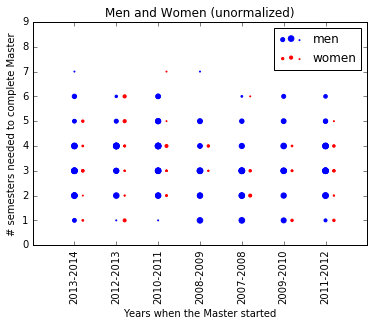

In [31]:
plt.figure()
plt.scatter(men.YearStarted, men.length, s=sizes_men, color='b', label='men')
plt.scatter(women.YearStarted+0.2, women.length, s=sizes_women, color='r', label='women')
plt.xlabel('Years when the Master started')
plt.ylabel('# semesters needed to complete Master')
plt.xticks(val, years, rotation='vertical')
plt.legend()
plt.title('Men and Women (unormalized)')
plt.show() 

Since there is a lot more male students than female, we normalize the data by the number of male/female students.

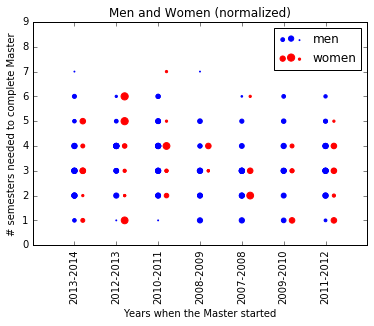

In [32]:
size = 400 # Just to get a good size on the plot
sizes_men_normalized = size*np.array(sizes_men/men.count()['length'])
sizes_women_normalized = size*np.array(sizes_women/women.count()['length'])

plt.figure()
plt.scatter(men.YearStarted, men.length, s=sizes_men_normalized, color='b', label='men')
plt.scatter(women.YearStarted+0.2, women.length, s=sizes_women_normalized, color='r', label='women')
plt.xlabel('Years when the Master started')
plt.ylabel('# semesters needed to complete Master')
plt.xticks(val, years, rotation='vertical')
plt.legend()
plt.title('Men and Women (normalized)')
plt.show() 

This graph is quite beautiful. But at the end, not that useful. Therefore, we can just say that Men and Women usually finish their Master in the same amount of time.